# The Marmousi elastic model

Let's make a synthetic dataset and write it out to a SEG-Y file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from obspy.io.segy.segy import _read_segy

In [2]:
ls -l ../data/marmousi

total 188120
-rw-r--r--@ 1 matt  staff      1350 27 Nov  2005 README
-rw-r--r--@ 1 matt  staff  74653200  6 Apr  1998 data.segy
-rw-r--r--@ 1 matt  staff   7096044 12 Sep  1991 density.segy
-rw-r--r--@ 1 matt  staff   7458840 14 Mar 12:51 synthetic_25Hz.sgy
-rw-r--r--@ 1 matt  staff   7096044 11 Sep  1991 velocity.segy


In [3]:
!cat ../data/marmousi/README

MARMOUSI DATA FILES - IEEE BIG ENDIAN FORMAT

The three files in this directory are

velocity.segy = Marmousi velocity model
density.segy  = Marmousi density model
data.segy     = Marmousi synthetic data

All three are SEGY disk images, but converted to IEEE big endian
format.

Many utilities can read these files or convert them to other
formats. Probably the easiest to access is the Seismic Unix segyread
command. [To obtain Seismic Unix, visit www.cwp.mines.edu/cwpcodes.]

To read these files into SU format, 

* on a big endian platform (Solaris or Linux on UltraSparc, 
Mac OS-X on PowerPC)

  segyread tape=xxx.segy conv=0 endian=1 > xxx.su

* on a little endian platform (Linux on Intel/AMD, DEC Alpha)  

  segyread tape=xxx.segy conv=0 endian=0 > xxx.su

where xxx = velocity, density, or data.

To obtain a flat binary file of data samples (minus the SEGY headers
included in the SU data format) us sustrip:

  sustrip < xxx.su > xxx.bin

The velocity and density files have nx = 2301, n

<hr />

We're going to make our own synthetic.

## Read the elastic data

In [4]:
velocity = _read_segy('../data/marmousi/velocity.segy')
density = _read_segy('../data/marmousi/density.segy')

In [5]:
velocity.binary_file_header

Binary File Header:
	job_identification_number: 1
	line_number: 1
	reel_number: 1
	number_of_data_traces_per_ensemble: 751
	number_of_auxiliary_traces_per_ensemble: 0
	sample_interval_in_microseconds: 2304
	sample_interval_in_microseconds_of_original_field_recording: 2304
	number_of_samples_per_data_trace: 2301
	number_of_samples_per_data_trace_for_original_field_recording: 2301
	data_sample_format_code: 1
	ensemble_fold: 1502
	trace_sorting_code: 1
	vertical_sum_code: 0
	sweep_frequency_at_start: 0
	sweep_frequency_at_end: 0
	sweep_length: 0
	sweep_type_code: 0
	trace_number_of_sweep_channel: 0
	sweep_trace_taper_length_in_ms_at_start: 0
	sweep_trace_taper_length_in_ms_at_end: 0
	taper_type: 0
	correlated_data_traces: 0
	binary_gain_recovered: 0
	amplitude_recovery_method: 0
	measurement_system: 0
	impulse_signal_polarity: 0
	vibratory_polarity_code: 0
	unassigned_1: b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

In [6]:
s = velocity.textual_file_header.decode()

print('\n'.join(map(''.join, zip(*[iter(s)]*80))))

C01 CLIENT                        COMPANY                       CREW NO         
C02 LINE            AREA                        MAP ID                          
C03 REEL NO.          DAY-START OF REEL     YEAR      OBSERVER                  
C04 INSTRUMENT: MFG            MODEL            SERIAL NO                       
C05 DATA TRACES/RECORD        AUXILIARY TRACES/RECORD         CDP FOLD          
C06 SAMPLE INTERVAL         SAMPLES/TRACE       BITS/IN      BYTES/SAMPLE       
C07 RECORDING FORMAT        FORMAT THIS REEL        MEASUREMENT SYSTEM          
C08 SAMPLE CODE: FLOATING PT     FIXED PT     FIXEDPT-GAIN     CORRELATED       
C09 GAIN  TYPE: FIXED     BINARY     FLOATING POINT     OTHER                   
C10 FILTERS: ALIAS     HZ  NOTCH     HZ  BAND     -     HZ  SLOPE    -    DB/OCT
C11 SOURCE: TYPE            NUMBER/POINT        POINT INTERVAL                  
C12     PATTERN:                           LENGTH        WIDTH                  
C13 SWEEP: START    HZ  END 

In [7]:
def get_data(section):
    nsamples = section.binary_file_header.number_of_samples_per_data_trace
    dt = section.binary_file_header.sample_interval_in_microseconds 

    ntraces = len(section.traces)  # Get from actual file contents.
    tbase = np.arange(0, nsamples * dt / 1000.0, dt)
    vol = np.stack(t.data for t in section.traces)
    ma, mi = np.amax(vol), np.amin(vol)

    print('number of traces (ntraces)   :', ntraces)
    print('samples per trace (nsamples) :', nsamples)
    print('sample interval              :', dt)
    print('data range                   : {} - {}'.format(mi, ma))

    return tbase, vol

In [8]:
t, vp = get_data(velocity)

number of traces (ntraces)   : 751
samples per trace (nsamples) : 2301
sample interval              : 2304
data range                   : 0.0 - 704000.0


In [9]:
_, rho = get_data(density)

number of traces (ntraces)   : 751
samples per trace (nsamples) : 2301
sample interval              : 2304
data range                   : 511.9375 - 131576.3125


## Deal with weirdness

The data are transposed: the so-called traces in the ObsPy stream are really timeslices, not traces. Very strange. We'll fix it.

In [10]:
vp.shape

(751, 2301)

In [11]:
vp = vp.T
rho = rho.T

nsamples = 751
t = np.linspace(0, (nsamples-1)*0.004, nsamples)

In [12]:
vp.shape

(2301, 751)

Now the data are organized correctly. We have to transpose them to display them, but the first dimension is traces.

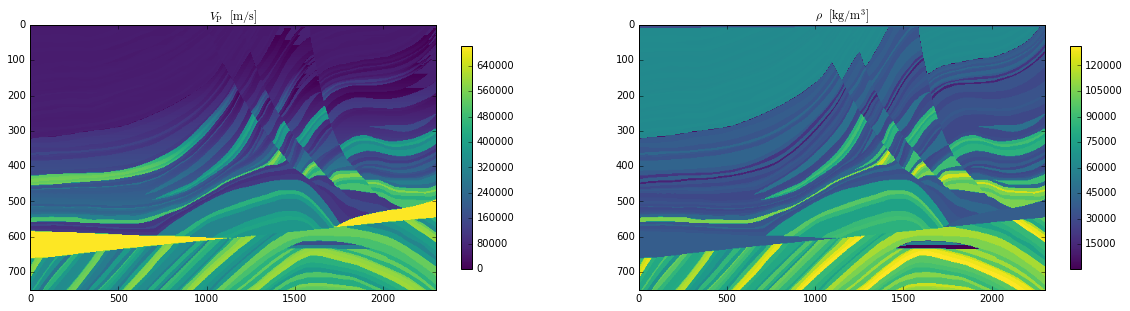

In [13]:
fig = plt.figure(figsize = (20,20))

ax1 = fig.add_subplot(121)
ax1.set_title(r'$V_\mathrm{P}\ \ \mathrm{[m/s]}$')
img = ax1.imshow(vp.T, aspect=2, cmap='viridis')
plt.colorbar(img, shrink=0.2)

ax2 = fig.add_subplot(122)
ax2.set_title(r'$\rho\ \ \mathrm{[kg/m^3]}$')
img = ax2.imshow(rho.T, aspect=2, cmap='viridis')
plt.colorbar(img, shrink=0.2)

plt.show()

## Make a synthetic

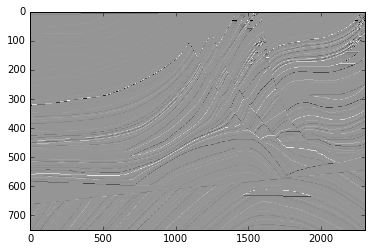

In [14]:
imp = vp * rho

def make_rc(imp):
    upper = imp[:,  :-1]
    lower = imp[:, 1:  ]
    
    return (lower - upper) / (lower + upper)

rc = make_rc(imp)

plt.imshow(rc.T, aspect=2, cmap="Greys")
plt.show()

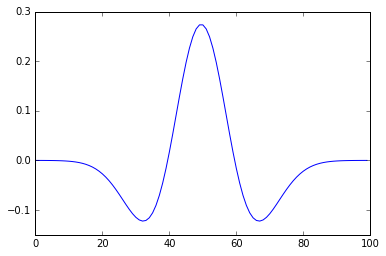

In [15]:
from scipy.signal import ricker

f = 25
wavelet = ricker(100, 1000/(4*f))

plt.plot(wavelet)
plt.show()

In [16]:
def convolve(trace):
    return np.convolve(trace, wavelet, mode='same')

synth = np.apply_along_axis(convolve,
                            axis=-1,
                            arr=rc)

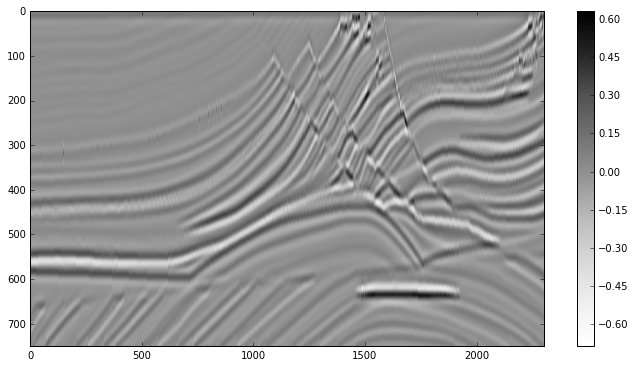

In [17]:
plt.figure(figsize=(12,6))
plt.imshow(synth.T, cmap="Greys", aspect=2)
plt.colorbar()
plt.show()

In [18]:
np.amin(synth), np.amax(synth)

(-0.68486304062743897, 0.63103389538291466)

In [19]:
synth.dtype

dtype('float64')

## Write a SEG-Y file

In [20]:
from obspy.core import Trace, Stream, UTCDateTime
from obspy.io.segy.segy import SEGYTraceHeader
from obspy.core import AttribDict
from obspy.io.segy.segy import SEGYBinaryFileHeader

If you're on a 64-bit machine and Python environment, the data are currently 64-bit — 8 bytes per sample. We don't want or need this many bytes, so we'll reduce the bit-depth to 32-bit:

In [21]:
synth = synth.astype(np.float32)
synth.dtype

dtype('float32')

In [22]:
stream = Stream()

# Add the traces to the stream.
for i, trace in enumerate(synth):

    # Make the trace.
    tr = Trace(trace)

    # Add required data.
    tr.stats.delta = 0.004
    tr.stats.starttime = 0  # Not strictly required.

    # Add yet more to the header (optional).
    tr.stats.segy = {'trace_header': SEGYTraceHeader()}
    tr.stats.segy.trace_header.trace_sequence_number_within_line = i + 1
    tr.stats.segy.trace_header.receiver_group_elevation = 0

    # Append the trace to the stream.
    stream.append(tr)
    
# Add a text header.
stream.stats = AttribDict()
stream.stats.textual_file_header = '{:80s}'.format('This is the textual header.').encode()
stream.stats.textual_file_header += '{:80s}'.format('This file contains seismic data.').encode()

# Add a binary header.
stream.stats.binary_file_header = SEGYBinaryFileHeader()
stream.stats.binary_file_header.trace_sorting_code = 4
stream.stats.binary_file_header.seg_y_format_revision_number = 0x0100

In [23]:
import sys

stream.write('../data/marmousi/synthetic_25Hz.sgy',
             format='SEGY',
             data_encoding=5,
             byteorder=sys.byteorder)

<hr />

© Agile Scientific 2017